In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os, sys
import pickle
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import time
import copy
import cv2 as cv

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
data_transforms = {
    'train': transforms.Compose([
        ##transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        transforms.RandomRotation(10)
        
    ]),
    
    'val': transforms.Compose([
        ##transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = "../datasets/split"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# path['train']는 train set의 경로
# path['test']는 val set의 경로

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)


{'train': 9896, 'val': 2475}


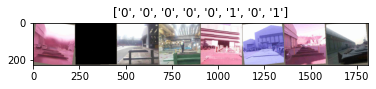

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 한개의 Bathc만큼 이미지를 불러온다. 배치사이를 4로 헀으니 4장이 로드된다. 
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

# 이미지를 출력한다. 
imshow(out, title=[class_names[x] for x in classes])

In [8]:
## 레즈넷 작은거
model_ft = models.resnet18(pretrained = True) #pretrained model을 가져온다.

# for param in model_ft.parameters(): # False로 설정함으로써 마지막 classifier를 제외한 모든 부분을 고정하여 backward()중에 경사도 계산이 되지 않도록 합니다.
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features # ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다.
model_ft.fc = nn.Linear(num_ftrs, 2)
# 이렇듯 Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델
# 본 예제에서는 Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같다.(개미와 벌 == 2)

model_ft = model_ft.to(device)

In [6]:
## 덴스넷
model_ft = models.densenet161(pretrained = True) #pretrained model을 가져온다.

# for param in model_ft.parameters(): # False로 설정함으로써 마지막 classifier를 제외한 모든 부분을 고정하여 backward()중에 경사도 계산이 되지 않도록 합니다.
#     param.requires_grad = False

num_ftrs = model_ft.classifier.in_features # ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다.
model_ft.fc = nn.Linear(num_ftrs, 2)
# 이렇듯 Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델
# 본 예제에서는 Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같다.(개미와 벌 == 2)

model_ft = model_ft.to(device)

In [7]:
# model_ft = torch.load("../model/resnet_0216")

FileNotFoundError: [Errno 2] No such file or directory: '../model/resnet_0216'

In [9]:
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    AUROCs = roc_auc_score(gt_np, pred_np)
    return AUROCs


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    train_acc = []
    val_acc = []
    train_auc = []
    val_auc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_auc = 0.0
    

    for epoch in range(num_epochs):
        since_epoch = time.time()
        print('Epoch {}/{}'.format(epoch + 1 , num_epochs)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            gt = torch.FloatTensor()
            gt = gt.cuda()
            pred_auc = torch.FloatTensor()
            pred_auc = pred_auc.cuda()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림

                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    m = nn.Softmax(dim=1)
                    preds = m(outputs)[:,1]
                    _, preds_max = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    
                    loss = criterion(outputs, labels) 
                    
                    if phase == 'val':
                        gt = torch.cat((gt, labels), 0)
#                         pred_auc = torch.cat((pred_auc, preds), 0)
                        pred_auc = torch.cat((pred_auc, preds_max), 0)

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds_max == labels.data)

                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc.append(epoch_acc)
            if phase == 'val':
                epoch_auc = compute_AUCs(gt, pred_auc)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            

            print('{}\t Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                print("val\t AUC: " + str(round(epoch_auc,4)))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        time_elapsed = time.time() - since_epoch
        print('Training complete of epoch in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        print()
        
    ## 그냥 마지막 모델을 사용
    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC: {:4f}'.format(best_auc))
    print('And  val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_auc, val_auc

In [10]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0002, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
epoch = 20
model_ft, train_acc, val_acc, train_auc, val_auc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch)

Epoch 1/20
----------
train	 Loss: 0.2973 Acc: 0.8764
val	 Loss: 0.1795 Acc: 0.9329
val	 AUC: 0.9249
Training complete of epoch in 8m 21s

Epoch 2/20
----------
train	 Loss: 0.1649 Acc: 0.9397
val	 Loss: 0.1101 Acc: 0.9584
val	 AUC: 0.955
Training complete of epoch in 3m 41s

Epoch 3/20
----------
train	 Loss: 0.1401 Acc: 0.9499
val	 Loss: 0.1417 Acc: 0.9515
val	 AUC: 0.9565
Training complete of epoch in 3m 37s

Epoch 4/20
----------
train	 Loss: 0.1180 Acc: 0.9602
val	 Loss: 0.0876 Acc: 0.9733
val	 AUC: 0.9693
Training complete of epoch in 3m 35s

Epoch 5/20
----------
train	 Loss: 0.1089 Acc: 0.9601
val	 Loss: 0.1429 Acc: 0.9628
val	 AUC: 0.9559
Training complete of epoch in 3m 42s

Epoch 6/20
----------
train	 Loss: 0.0990 Acc: 0.9647
val	 Loss: 0.0658 Acc: 0.9774
val	 AUC: 0.9765
Training complete of epoch in 3m 36s

Epoch 7/20
----------
train	 Loss: 0.0842 Acc: 0.9728
val	 Loss: 0.0745 Acc: 0.9729
val	 AUC: 0.9721
Training complete of epoch in 3m 35s

Epoch 8/20
----------
train	

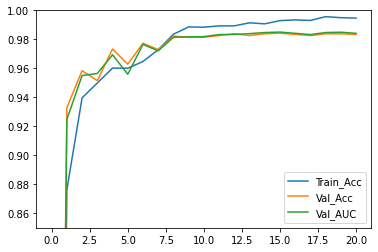

In [12]:
train_acc = [x.cpu() for x in train_acc]
val_acc = [x.cpu() for x in val_acc]

plt.plot(range(0,epoch+1), [0] + train_acc, label = 'Train_Acc')
plt.plot(range(0,epoch+1), [0] + val_acc,label = 'Val_Acc')
plt.plot(range(0,epoch+1), [0] + val_auc,label = 'Val_AUC')

plt.legend()
plt.ylim([0.85, 1])
plt.show()


In [13]:
PATH = "./weights/"
torch.save(model_ft, PATH + "ResNet_basic_0218" + ".pt")